In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC

from post_LED_censor_utils import rho_A_t_fn, cum_A_t_fn, CDF_rho_times_P_x_t_fn, CDF_v_change_till_stim_trunc_adj_fn, PDF_t_v_change
from scipy.integrate import trapezoid as trapz
from post_LED_fit_utils import d_A_RT_SCALAR, stupid_f_integral_SCALAR, PA_with_LEDON_2_SCALAR, d_A_RT_VEC, stupid_f_integral_VEC, PA_with_LEDON_2_VEC

# data

In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# drop rows from df where intended_fix, LED_onset_time and timed_fix are nan
df = df.dropna(subset=['intended_fix', 'LED_onset_time', 'timed_fix'])
tuple_column = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))

In [3]:
df_led_on = df[df['LED_trial'] == 1]
df_led_on = df_led_on[(df_led_on['abort_event'] == 3) | (df_led_on['success'].isin([1,-1]))]
print(f'len(df_led_on) = {len(df_led_on)}')

len(df_led_on) = 30910


# likelihood

In [4]:
T_trunc = 0.3

In [5]:
V_A = 1.59
theta_A = 2.53
# total proactive delay
total_proactive_delay = -0.187

In [6]:
t_pts_for_trunc = np.arange(0, T_trunc, 0.001)
def compute_loglike(row, post_LED_drift, motor_delay):
    delta_i = total_proactive_delay - motor_delay
    tfix = 0

    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    # truncation factor
    PA_vec = PA_with_LEDON_2_VEC(t_pts_for_trunc, V_A, post_LED_drift, theta_A, tfix, t_LED, delta_i, motor_delay)
    trunc_factor = 1 - trapz(PA_vec, t_pts_for_trunc)
    
    if rt < T_trunc:
        likelihood = 0
    else:
        if rt <= t_stim: # abort
            if rt - motor_delay - t_LED < 0: 
                # RT - motor - t_LED < 0 => time travelled with V2 is negative, which is not possible
                # Remedy 1: likelihood = 0
                # likelihood = 0

                # Remedy 2: Assume it hit with a single drift only
                v = V_A
                a = theta_A
                likelihood = d_A_RT_SCALAR(v * a, (rt - (delta_i + motor_delay) + tfix) / (a**2)) / (a**2)
            else:
                likelihood = PA_with_LEDON_2_SCALAR(rt, V_A, post_LED_drift, theta_A, tfix, t_LED, delta_i, motor_delay)
        else: # valid trial
            # censored likelihood after t_stim
            t_pts_for_censor = np.arange(t_stim, 5, 0.005)
            PA_after_tstim = PA_with_LEDON_2_VEC(t_pts_for_censor, V_A, post_LED_drift, theta_A, tfix, t_LED, delta_i, motor_delay)
            CDF_after_tstim = trapz(PA_after_tstim, t_pts_for_censor)
            likelihood = CDF_after_tstim


    likelihood /= trunc_factor
            
                

    if likelihood <= 0:
        likelihood = 1e-50
    
    return np.log(likelihood)
    

def vbmc_loglike_fn(params):
    post_LED_drift, motor_delay = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, post_LED_drift, motor_delay)\
                                      for _, row in df_led_on.iterrows())
    
    return np.sum(all_loglike)
   

# bounds

In [7]:
post_LED_drift_bounds = [1, 10]
post_LED_drift_plausible_bounds = [1.5, 3.5]

motor_delay_bounds = [0, 0.1]
motor_delay_plausible_bounds = [0.01, 0.07]

# prior

In [8]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    post_LED_drift, motor_delay = params

    post_LED_drift_logpdf = trapezoidal_logpdf(post_LED_drift, post_LED_drift_bounds[0], post_LED_drift_plausible_bounds[0], post_LED_drift_plausible_bounds[1], post_LED_drift_bounds[1])
    motor_delay_logpdf = trapezoidal_logpdf(motor_delay, motor_delay_bounds[0], motor_delay_plausible_bounds[0], motor_delay_plausible_bounds[1], motor_delay_bounds[1])

    return post_LED_drift_logpdf + motor_delay_logpdf

# joint

In [9]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + vbmc_loglike_fn(params)

# run vbmc

In [ ]:
lb = [post_LED_drift_bounds[0], motor_delay_bounds[0]]
ub = [post_LED_drift_bounds[1], motor_delay_bounds[1]]

plb = [post_LED_drift_plausible_bounds[0], motor_delay_plausible_bounds[0]]
pub = [post_LED_drift_plausible_bounds[1], motor_delay_plausible_bounds[1]]

np.random.seed(42)
post_LED_drift_0 = np.random.uniform(post_LED_drift_plausible_bounds[0], post_LED_drift_plausible_bounds[1])
motor_delay_0 = np.random.uniform(motor_delay_plausible_bounds[0], motor_delay_plausible_bounds[1])

x_0 = np.array([post_LED_drift_0, motor_delay_0])

vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

# corner

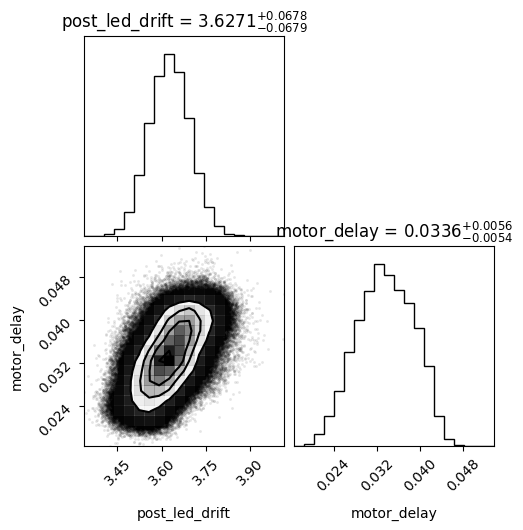

In [11]:
import corner
vp_samples = vp.sample(int(1e6))[0]
post_led_drift_samp = vp_samples[:, 0]
motor_delay_samp = vp_samples[:, 1]

# combined_samples = np.transpose(np.vstack((base_V_A_samp, theta_A_samp, t_A_aff_samp)))
# param_labels = ['base_V_A', 'theta_A', 't_A_aff']

combined_samples = np.transpose(np.vstack((post_led_drift_samp, motor_delay_samp)))
param_labels = ['post_led_drift', 'motor_delay']

corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f");


In [12]:
post_LED_drift_mean = np.mean(post_led_drift_samp)
motor_delay_mean = np.mean(motor_delay_samp)

# simulate data

In [29]:
dt = 1e-4; dB = 1e-2
v1 = V_A; v2 = post_LED_drift_mean; a = theta_A
delta_i = total_proactive_delay - motor_delay_mean
delta_m = motor_delay_mean
def simulate_led_proactive_fn(t_LED):
    dv = 0; t = delta_i
    while True:
        if t <= t_LED:
            v = v1
        else:
            v = v2
        
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv >= a:
            return t + delta_m, t_LED


N_sim = int(50e3)
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
random_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim, replace=True)
sim_rts = Parallel(n_jobs=30)(delayed(simulate_led_proactive_fn)(t_stim_and_led_tuple[i][1]) for i in tqdm(range(N_sim)))

100%|██████████| 50000/50000 [00:22<00:00, 2242.21it/s]


# abort rate with this new params

In [23]:
# df_led_on = df_led_on[df_led_on['abort_event'] == 3 | df_led_on['success'].isin([1,-1])]
df_led_on_aborts = df_led_on[df_led_on['abort_event'] == 3]
# remove aborts < .3
df_led_on_aborts = df_led_on_aborts[df_led_on_aborts['timed_fix'] > 0.3]

# wrt fixation

In [42]:
N_theory = int(10e3)
t_pts = np.arange(0, 2, 0.001)

P_A_samples = np.zeros((N_theory, len(t_pts)))
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]

delta_i = total_proactive_delay - motor_delay_mean
indices = np.random.choice(len(df_led_on_aborts), N_theory)

# for i in tqdm(range(N_theory)):
for i in tqdm(range(len(indices))):

    _, t_LED = t_stim_and_led_tuple[indices[i]]
    P_A_samp = PA_with_LEDON_2_VEC(t_pts, V_A, post_LED_drift_mean, theta_A, 0, t_LED, delta_i, motor_delay_mean)
    P_A_samples[i, :] = P_A_samp

P_A_samp_mean = np.mean(P_A_samples, axis=0)

100%|██████████| 10000/10000 [00:01<00:00, 5773.56it/s]


In [43]:
# sim
sim_rts_wrt_fix = np.array([rt for rt, _ in sim_rts])
# remote rts < 0.3
sim_rts_wrt_fix = sim_rts_wrt_fix[sim_rts_wrt_fix > 0.3]

area_till_T_trunc = 0.018180997605038274
trunc_factor = 0.9818190023949618
area P_A_samp_mean = 0.993507494514716


Text(0.5, 1.0, 'wrt fixation')

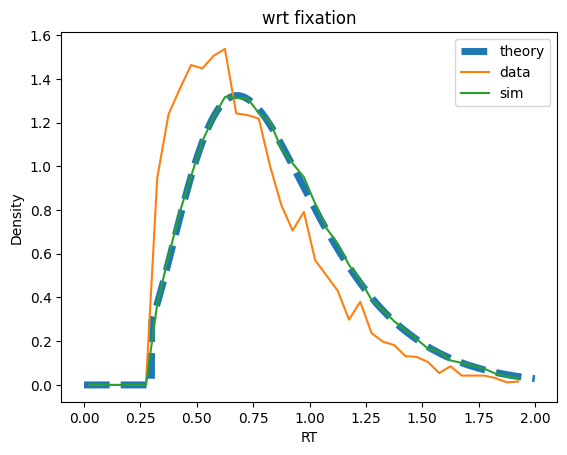

In [44]:
# wrt fixation
# frac_aborts = len(df_led_on_aborts) / len(df_led_on)
bins = np.arange(0, 2, 0.05)


# theory
T_trunc_idx = np.where(t_pts >= T_trunc)[0][0]
area_till_T_trunc = trapz(P_A_samp_mean[:T_trunc_idx], t_pts[:T_trunc_idx])
print(f'area_till_T_trunc = {area_till_T_trunc}')
trunc_factor = 1 - area_till_T_trunc
print(f'trunc_factor = {trunc_factor}')
P_A_samp_mean[:T_trunc_idx] = 0
P_A_samp_mean[T_trunc_idx:] /= trunc_factor
print(f'area P_A_samp_mean = {trapz(P_A_samp_mean, t_pts)}')
plt.plot(t_pts, P_A_samp_mean, label='theory', lw=5, ls='--')


# data
df_led_on_aborts_rt = df_led_on_aborts['timed_fix']
frac_aborts = 1

aborts_hist, _ = np.histogram(df_led_on_aborts_rt, bins=bins, density=True)
aborts_hist *= frac_aborts
bin_centers = (bins[1:] + bins[:-1]) / 2
plt.plot(bin_centers, aborts_hist, label='data')



# sim
sim_hist, _ = np.histogram(sim_rts_wrt_fix, bins=bins, density=True)
plt.plot(bin_centers, sim_hist, label='sim')

plt.xlabel('RT')
plt.ylabel('Density')
plt.legend()
plt.title('wrt fixation')

# wrt led

In [37]:
N_theory = int(5e3)
t_pts = np.arange(-2, 2, 0.005)

P_A_samples = np.zeros((N_theory, len(t_pts)))
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]

delta_i = total_proactive_delay - 0.04
indices = np.random.choice(len(df_led_on_aborts), N_theory)

for i in tqdm(range(len(indices))):
    _, t_LED = t_stim_and_led_tuple[indices[i]]
    P_A_samp = PA_with_LEDON_2_VEC(t_pts + t_LED, V_A, post_LED_drift_mean, theta_A, 0, t_LED, delta_i, motor_delay_mean)
    
    P_A_samples[i, :] = P_A_samp

P_A_samp_mean = np.mean(P_A_samples, axis=0)

100%|██████████| 5000/5000 [00:00<00:00, 10903.49it/s]


area = 1.0001821965617477


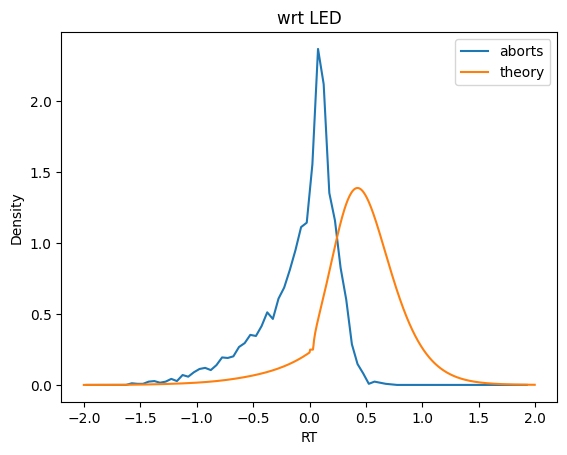

In [ ]:
#

frac_aborts = 1

df_led_on_aborts_rt = df_led_on_aborts['timed_fix'] - ( df_led_on_aborts['intended_fix'] - df_led_on_aborts['LED_onset_time'] )
bins = np.arange(-2, 2, 0.05)
aborts_hist, _ = np.histogram(df_led_on_aborts_rt, bins=bins, density=True)
aborts_hist *= frac_aborts
bin_centers = (bins[1:] + bins[:-1]) / 2
plt.plot(bin_centers, aborts_hist, label='aborts')
plt.plot(t_pts, P_A_samp_mean, label='theory')
plt.xlabel('RT')
plt.ylabel('Density')
plt.legend()
plt.title('wrt LED')

print(f'area = {trapz(P_A_samp_mean, t_pts)}')


# debug

In [ ]:
from scipy.special import erf
def d_A_RT_VEC_DEBUG(a, t):
    """
    Calculate the standard PA probability density function (vectorized).

    Parameters:
        a (float): Scalar parameter.
        t (numpy.ndarray): Time values (must be > 0).

    Returns:
        numpy.ndarray: The computed pdf values (0 where t <= 0).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    p = np.zeros_like(t)
    valid_indices = t > 0
    p[valid_indices] = (1.0 / np.sqrt(2 * np.pi * (t[valid_indices]**3))) * np.exp(-((1 - a * t[valid_indices])**2) / (2 * t[valid_indices]))
    return p

def stupid_f_integral_VEC_DEBUG(v, vON, theta, t, tp):
    """
    Calculate the PA pdf after the v_A change via an integral expression (vectorized).

    Parameters:
        v (float): Scalar parameter.
        vON (float): Scalar parameter.
        theta (float): Scalar parameter.
        t (numpy.ndarray): Time values.
        tp (numpy.ndarray): A shifted time values.

    Returns:
        numpy.ndarray: The evaluated integral expressions.
    """
    t = np.asarray(t)
    tp = np.asarray(tp)
    a1 = 0.5 * (1 / t + 1 / tp)
    b1 = theta / t + (v - vON)
    c1 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp)

    a2 = a1
    b2 = theta * (1 / t + 2 / tp) + (v - vON)
    c2 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp + 4 * theta * v + 4 * theta**2 / tp) + 2 * v * theta

    F01 = 1.0 / (4 * np.pi * a1 * np.sqrt(tp * t**3))
    F02 = 1.0 / (4 * np.pi * a2 * np.sqrt(tp * t**3))

    T11 = b1**2 / (4 * a1)
    T12 = (2 * a1 * theta - b1) / (2 * np.sqrt(a1))
    T13 = theta * (b1 - theta * a1)

    T21 = b2**2 / (4 * a2)
    T22 = (2 * a2 * theta - b2) / (2 * np.sqrt(a2))
    T23 = theta * (b2 - theta * a2)

    I1 = F01 * (T12 * np.sqrt(np.pi) * np.exp(T11 + c1) * (erf(T12) + 1) + np.exp(T13 + c1))
    I2 = F02 * (T22 * np.sqrt(np.pi) * np.exp(T21 + c2) * (erf(T22) + 1) + np.exp(T23 + c2))

    STF = I1 - I2
    return STF


def PA_with_LEDON_2_VEC_DEBUG(t, v, vON, a, tfix, tled, delta_i, delta_m):
    """
    Compute the PA pdf by combining contributions before and after LED onset (vectorized).

    Parameters:
        t (numpy.ndarray): Time values.
        v (float): Drift parameter before LED.
        vON (float): Drift parameter after LED onset.
        a (float): Decision bound.
        tfix (float): Fixation time.
        tled (float): LED time.
        delta_i (float): Delta parameter for proactive delay.
        delta_m (float): Motor delay parameter.

    Returns:
        numpy.ndarray: The combined PA pdf values.
    """
    t = np.asarray(t)
    result = np.zeros_like(t)
    
    before_led = (t + tfix) <= (tled + 1e-6)
    result[before_led] = d_A_RT_VEC_DEBUG(v * a, (t[before_led] - (delta_i + delta_m) + tfix) / (a**2)) / (a**2)
    
    # Compute the time difference for the post-LED condition and clip negatives to 0.001.
    t_post_led = t[~before_led] + tfix - delta_m - tled
    t_post_led = np.clip(t_post_led, 1e-6, None)  # Clip any value below 0.001 to 0.001

    tp_post_led = tled + tfix - delta_i
    tp_post_led = np.clip(tp_post_led, 1e-6, None)  # Clip any value below 0.001
    
    result[~before_led] = stupid_f_integral_VEC_DEBUG(v, vON, a, t_post_led, tp_post_led)

    return result


# simulation

In [ ]:
dt = 1e-4; dB = 1e-2
v1 = 1.6; v2 = 3.4; a = 2.53
delta_i = 0.02
delta_m = 0.04
def simulate_led_proactive_fn(t_LED):
    dv = 0; t = delta_i
    while True:
        if t <= t_LED:
            v = v1
        else:
            v = v2
        
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv >= a:
            return t + delta_m, t_LED

In [ ]:
N_sim = int(50e3)
random_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)

sim_rts = Parallel(n_jobs=30)(delayed(simulate_led_proactive_fn)(t_stim_and_led_tuple[i][1]) for i in tqdm(range(N_sim)))

In [ ]:
def PA_with_LEDON_2_SCALAR_DEBUG(t, v, vON, a, tfix, tled, delta_i, delta_m):
    """
    Compute the PA pdf by combining contributions before and after LED onset for scalar inputs.

    Parameters:
        t (float): Time value.
        v (float): Drift parameter before LED.
        vON (float): Drift parameter after LED onset.
        a (float): Decision bound.
        tfix (float): Fixation time.
        tled (float): LED time.
        delta_A (float): Delta parameter.

    Returns:
        float: The combined PA pdf value.
    """
    # Check if the time (with fixation) is before the LED onset.
    if (t + tfix) <= (tled + 1e-6):
        # Use the scalar version of d_A_RT: note that d_A_RT_SCALAR must be defined.
        result = d_A_RT_SCALAR(v * a, (t - (delta_i + delta_m) + tfix) / (a**2)) / (a**2)
    else:
        if t + tfix - delta_m - tled <= 0 :
            print(f't = {t}, tfix = {tfix}, delta_m = {delta_m}, tled = {tled}')
            print(f't + tfix - delta_m - tled = {t + tfix - delta_m - tled}')
            raise Exception('t + tfix - delta_m - tled < 0')
        if tled + tfix - delta_i + 1e-6 <= 0:
            print(f't = {t}, tfix = {tfix}, delta_i = {delta_i}, tled = {tled}')
            print(f'tled + tfix - delta_i = {tled + tfix - delta_i}')
            raise Exception('tled + tfix - delta_i < 0')
        # Use the scalar version of stupid_f_integral: note that stupid_f_integral_SCALAR must be defined.
        result = stupid_f_integral_SCALAR(v, vON, a, t + tfix - delta_m  - tled, tled + tfix - delta_i + 1e-6)
    return result


N_theory = int(5e3)
t_pts = np.arange(-2, 2, 0.005)
P_A_samples = np.zeros((N_theory, len(t_pts)))
for i in tqdm(range(N_theory)):
    _, t_LED = sim_rts[i]
    P_A_samp = PA_with_LEDON_2_VEC_DEBUG(t_pts + t_LED, v1, v2, theta_A, 0, t_LED, delta_i, delta_m)
    # P_A_samp = [PA_with_LEDON_2_SCALAR_DEBUG(t + t_LED, v1, v2, theta_A, 0, t_LED, delta_i, delta_m) for t in t_pts]
    P_A_samples[i, :] = P_A_samp

P_A_samp_mean = np.mean(P_A_samples, axis=0)

In [ ]:
sim_rt_wrt_led = np.array([rt - t_LED for rt, t_LED in sim_rts])
bins = np.arange(-2, 2, 0.05)
sim_hist, _ = np.histogram(sim_rt_wrt_led, bins=bins, density=True)
bin_centers = (bins[1:] + bins[:-1]) / 2
plt.plot(bin_centers, sim_hist, label='sim')
plt.plot(t_pts, P_A_samp_mean, label='theory')
plt.xlabel('RT')
plt.ylabel('Density')
plt.legend()

In [ ]:
np.clip(2, 1e-6, None)